<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib.dates as mdates
import scipy as sp
from scipy import signal
from datetime import timedelta, datetime

# Power Spectral Density, Periodogram

The parameters below are defined such that there are $NT=20000$ data points with a samply frequency of $f=1/dt=10~\text{Hz}$. The Nyquist frequency (lowest possible resolved frequency) is given by $f_N=f/2$. The amplitudes and frequencies of the signal are chosen to match what is required on the assignment.

In [2]:
NT1 = 20000
NT2 = 2000
dt = 1/10
f_N = 1/(2*dt)

A = [250, 34, 8, 10]

w1 = 2*np.pi*f_N/100
w2 = 4.3*w1
w3 = 4.7*w1
w4 = 2*np.pi*f_N/500

W = [w1, w2, w3, w4]

The functions below are used to create the signal and the noise.

In [3]:
def CN(sigma, N):
    return sigma*np.random.randn(N)

def signal(NT, dt, A, W):
    sig = np.zeros(NT)
    t = np.arange(0, NT, 1)*dt
    
    for a,w in zip(A,W):
        sig += a*np.cos(w*t)
    
    return sig

# Signal created ...
t1 = np.arange(0, NT1, 1)*dt
x1 = CN(20, NT1)+signal(NT1, dt, A, W)
t2 = np.arange(0, NT2, 1)*dt
x2 = CN(20, NT2)+signal(NT2, dt, A, W)

## Plot The Signal

We plot signal 2 in red over top of signal 1 in order to show how dramtic the total measurement time difference is.

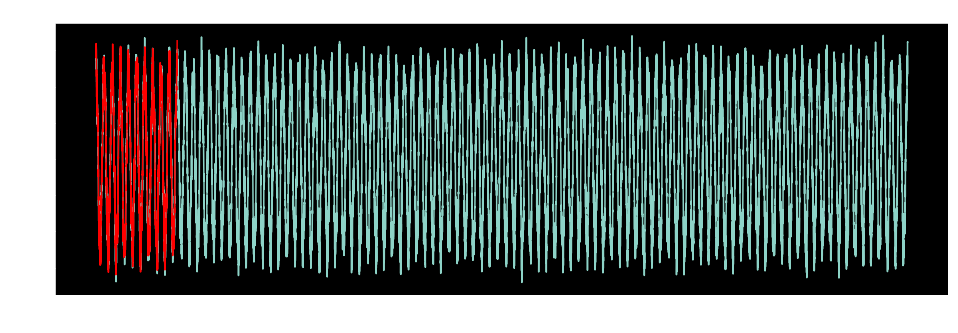

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16,5))

ax.plot(t1,x1)
ax.plot(t2,x2, color='r')
ax.set_title('Signal Sample 1 (Blue) and 2 (Red)')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude [arb]')

plt.show()

Below we take the Fourier transform of the signal and use it to plot the power spectral density $G_{xx}(f)$. We only include positive frequencies.

In [5]:
X1 = np.fft.fft(x1)
X2 = np.fft.fft(x2)
ii1 = range(0,int(NT1/2))
ii2 = range(0,int(NT2/2))

# Signal 1
fq1 = np.arange(0, int(NT1/2), 1)/(NT1*dt)
Gxx1 = np.abs(X1[ii1])**2 /(NT1/2)  # divide to normalize

# Signal 2
fq2 = np.arange(0, int(NT2/2), 1)/(NT2*dt)
Gxx2 = np.abs(X2[ii2])**2 /(NT2/2)

## Plot the 1-Sided Power Spectral Density

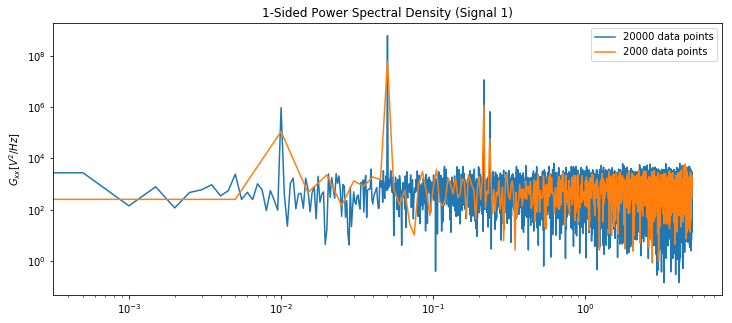

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.loglog(fq1,Gxx1, label='{} data points'.format(20000))
ax.loglog(fq2,Gxx2, label='{} data points'.format(2000))
ax.set_title('1-Sided Power Spectral Density (Signal 1)')
ax.set_ylabel('$G_{xx}[V^2/Hz]$')
ax.legend()

plt.show()

The signal measured for less time has less resolution in the power spectral density, and can't resolve frequencies as small as the larger signal.

We can also calculate the 95% confidence interval for each point of $G_{xx}(f)$ using

$$95\% \text{CI} =[G_{min}, G_{max}] $$

These limits are given by

$$G_{min} = \frac{nG_{xx}(f)}{2f(1-\alpha/2, n)} \hspace{20mm} G_{max} = \frac{nG_{xx}(f)}{2f(\alpha/2, n)}$$

where $n$ is the degrees of freedom and $f$ is the inverse chi squared distribution with $n$ degrees of freedom.

In [8]:
n = 2 # degrees of freedom
a = 0.05 # 95% confidence

Gmin1 = n*Gxx1/(2*sp.stats.chi2.ppf(1-a/2,n))
Gmax1 = n*Gxx1/(2*sp.stats.chi2.ppf(a/2,n))

Gmin2 = n*Gxx2/(2*sp.stats.chi2.ppf(1-a/2,n))
Gmax2 = n*Gxx2/(2*sp.stats.chi2.ppf(a/2,n))

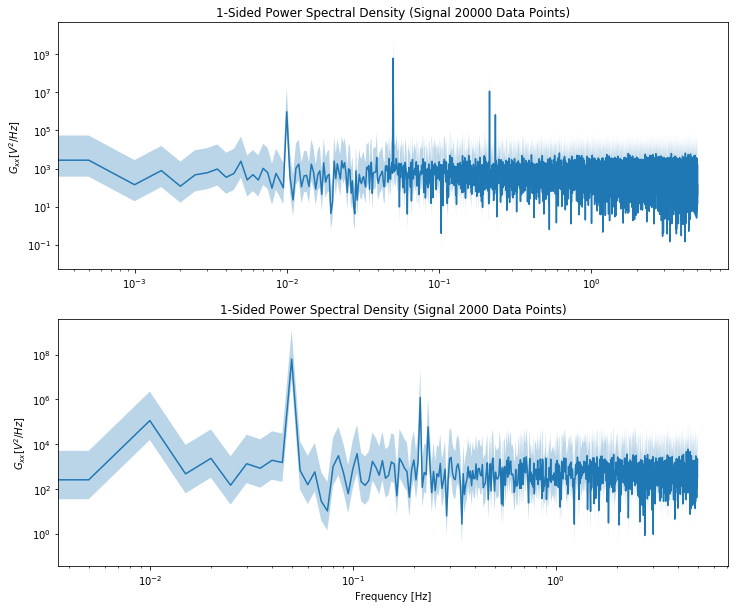

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
axes[0].loglog(fq1,Gxx1)
axes[0].set_title('1-Sided Power Spectral Density (Signal 20000 Data Points)')
axes[0].set_ylabel('$G_{xx}[V^2/Hz]$')
axes[0].fill_between(fq1, Gmin1, Gmax1, alpha=0.3) #Used for Uncertainties

axes[1].loglog(fq2,Gxx2)
axes[1].set_title('1-Sided Power Spectral Density (Signal 2000 Data Points)')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('$G_{xx}[V^2/Hz]$')
axes[1].fill_between(fq2, Gmin2, Gmax2, alpha=0.3) #Used for Uncertainties

plt.show()

## Questions

1) Increasing the record length clearly permits higher resolution, but still estimates the peaks to be at approximately the same location. If our total time $T$ was small enough, however, such that $f_1=1/T$ was greater than our first peak, then we would not be able to measure our first peak at approximately $10^{-2}$Hz. Our estimate would miss out on one of the frequencies of the signal.

2) Since the frequency spacing $\Delta f = 1/(N \Delta t)$, a larger sample size increases the frequency resolution.

# Use Built-In Function pwelch

The arguments to the function are $x1$: The array of signal values, $fs$: the sampling rate, **window**: The type of window (boxcar, hanning, ...) used for seperating the intervals, **nperseg**: the number of points used per segment and **noverlap**: the number of overlapping points between intervals.

In [10]:
NT = NT1
N1 = 2**14
N2 = 2**11
N3 = 2**9

f1, X1 = sp.signal.welch(x1, fs=10, window='hanning', nperseg=N1, noverlap = N1 / 2)
f2, X2 = sp.signal.welch(x1, fs=10, window='hanning', nperseg=N2, noverlap = N2 / 2)
f3, X3 = sp.signal.welch(x1, fs=10, window='hanning', nperseg=N3, noverlap = N3 / 2)

## Plots Without Uncertainties

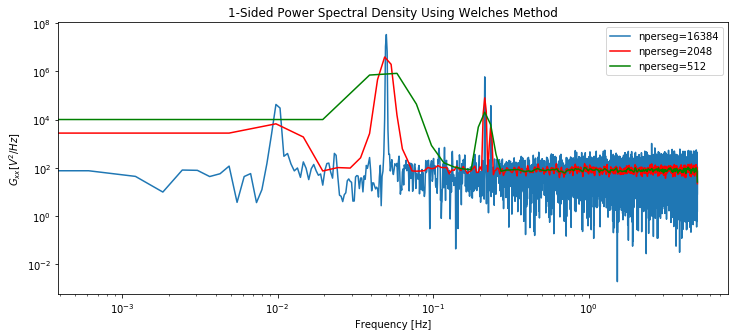

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.loglog(f1,X1, label='nperseg=16384')
ax.loglog(f2,X2, color='r', label='nperseg=2048')
ax.loglog(f3,X3, color='g', label='nperseg=512')
ax.set_title('1-Sided Power Spectral Density Using Welches Method')
ax.set_ylabel('$G_{xx}[V^2/Hz]$')
ax.set_xlabel('Frequency [Hz]')
ax.legend(loc='best')

plt.show()

For calculating uncertainties, the degrees of freedom is given by 

$$n_{free} = 2(2\lfloor N/n_{perseg} \rfloor-1) $$

where $N$ is the total number of data points and $n_{perseg}$ is the number of points used per segment in Welch's method.

In [12]:
nf1 = 2*(2*np.floor(NT/N1)-1)
nf2 = 2*(2*np.floor(NT/N2)-1)
nf3 = 2*(2*np.floor(NT/N3)-1)

a = 0.05 # 95% confidence

Xmin1 = nf1*X1/(2*sp.stats.chi2.ppf(1-a/2,nf1))
Xmax1 = nf1*X1/(2*sp.stats.chi2.ppf(a/2,nf1))

Xmin2 = nf2*X2/(2*sp.stats.chi2.ppf(1-a/2,nf2))
Xmax2 = nf2*X2/(2*sp.stats.chi2.ppf(a/2,nf2))

Xmin3 = nf3*X3/(2*sp.stats.chi2.ppf(1-a/2,nf3))
Xmax3 = nf3*X3/(2*sp.stats.chi2.ppf(a/2,nf3))

## Plots with Uncertainties

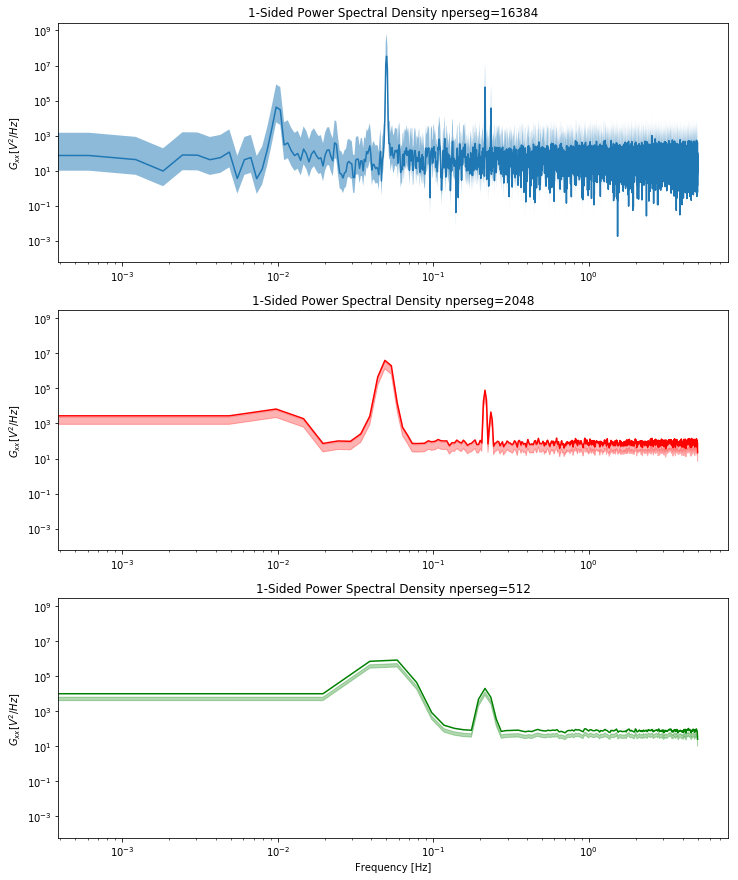

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(12,15))
axes[0].loglog(f1,X1)
axes[0].set_title('1-Sided Power Spectral Density nperseg=16384')
axes[0].set_ylabel('$G_{xx}[V^2/Hz]$')
axes[0].fill_between(f1, Xmin1, Xmax1, alpha=0.5) #Used for Uncertainties

axes[1].loglog(f2,X2, color='r')
axes[1].set_title('1-Sided Power Spectral Density nperseg=2048')
axes[1].set_ylabel('$G_{xx}[V^2/Hz]$')
axes[1].fill_between(f2, Xmin2, Xmax2, alpha=0.3, color='r') #Used for Uncertainties
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())

axes[2].loglog(f3,X3, color='g')
axes[2].set_title('1-Sided Power Spectral Density nperseg=512')
axes[2].set_xlabel('Frequency [Hz]')
axes[2].set_ylabel('$G_{xx}[V^2/Hz]$')
axes[2].fill_between(f3, Xmin3, Xmax3, alpha=0.3, color='g') #Used for Uncertainties
axes[2].set_xlim(axes[0].get_xlim())
axes[2].set_ylim(axes[0].get_ylim())

plt.show()

These plots were intentionally all drawn on the same $y$ scale. While it is clear that large $n_{perseg}$ has high precision when determining the energy in certain frequencies, it also has the highest uncertainties. We can trade-off these large uncertainties for lower resolution by using smaller intervals in Welch's method. Clearly $n_{perseg}=512$ can't discriminate between the two highest frequencies, so it is no good. $n_{perseg}=2048$ has small uncertainties and can discriminate between the two highest frequencies, making it a good choice for high frequency discrimation. It doesn't, however, give the large peak at low frequncies that $n_{perseg}=16384$ yields. In conclusion, it depends on what we're looking for...

**High Resolution (But High Uncertainty) of Energy Distribution at High Frequencies:** $n_{perseg}=16384$

**Low Uncertainty (But Low Resolutuion) of Energy Distribution at High Frequencies:** $n_{perseg}=2048$